In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm

In [2]:
train_df = pd.read_csv("../csv_files/train.csv")
weather_df = pd.read_csv("../csv_files/weather.csv")

### We came at the preprocessing part after doing all the analysis and it was observed that weather.csv file contained missing values

In [3]:
weather_df.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,,0.0,0.00,29.77,30.47,9.9,31,10.0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,,0.0,0.00,29.79,30.48,8.0,35,8.2
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,,0.0,0.00,29.95,30.47,14.0,36,13.8


* #### let's look at the missing values in weather_df
* #### Missing values are denoted by '-','M' and 'T'

In [4]:
missing_df = pd.DataFrame(columns =['column_name','nbr_missing_vals'])
row_index = 0
for col in weather_df.columns:
    missing_df.loc[row_index,'column_name'] = col
    ser = weather_df[col].isin(['-',' ','M','T']).value_counts()
    if len(ser) > 1:
        missing_df.loc[row_index,'nbr_missing_vals'] = ser[1]
    else:
        missing_df.loc[row_index,'nbr_missing_vals'] = 0
    row_index += 1

<AxesSubplot:xlabel='column_name', ylabel='nbr_missing_vals'>

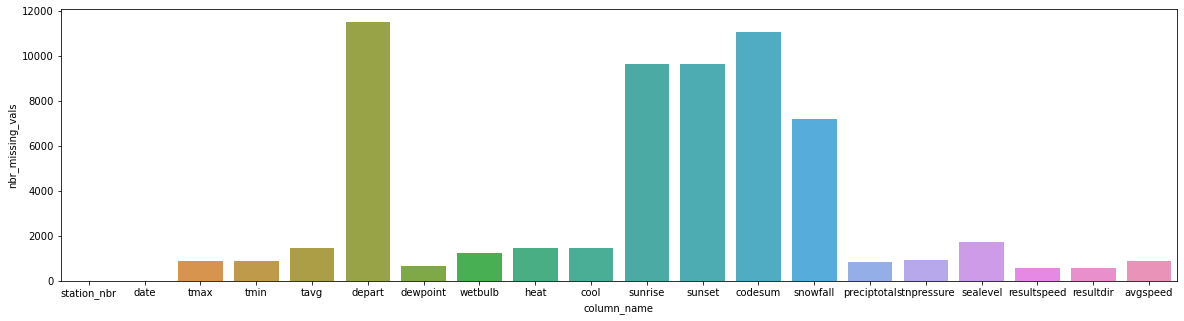

In [5]:
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize=(20,5))
sns.barplot(x = 'column_name', y = 'nbr_missing_vals', data=missing_df)

* #### To fill in the missing values which are numerical we'll use a simple strategy for now which is group by station_nbr and take average for each column.
* #### For categorical values we can use mode values which are obtained after groupby of station_nbr.
* #### Later while modelling we'll try more methods depending on how better the results are.

#### Replacing all missing values by -1000 to be imputed later with actual means and modes

In [6]:
weather_df.codesum = weather_df.codesum.apply(lambda x : x.strip())

In [7]:
weather_df.replace('M','-1000',inplace=True)
weather_df.replace('  T','-1000',inplace=True)
weather_df.replace('-','-1000',inplace=True)
weather_df.replace('','-1000',inplace=True)

In [8]:
datetime_columns = ['date']
categorical_columns = ['station_nbr','codesum','sunrise','sunset']

def change_datatype():
    """
        This function is used to return a dictionary of column and it's corresponding correct datatype
    """
    numerical_columns = [col for col in weather_df.columns if ((col not in categorical_columns) and (col not in datetime_columns))]
    datatypes = weather_df.dtypes.to_dict()
    for column in numerical_columns:
        datatypes[column] = 'float'
    for column in categorical_columns:
        datatypes[column] = 'object'
    dtp = OrderedDict()
    for (k, v) in datatypes.items():
        dtp[k] = str(v)

    print("Column datatypes : ",dtp)
    return dtp, numerical_columns

In [9]:
dtp, num_cols = change_datatype()
weather_df = weather_df.astype(dtp)

Column datatypes :  OrderedDict([('station_nbr', 'object'), ('date', 'object'), ('tmax', 'float'), ('tmin', 'float'), ('tavg', 'float'), ('depart', 'float'), ('dewpoint', 'float'), ('wetbulb', 'float'), ('heat', 'float'), ('cool', 'float'), ('sunrise', 'object'), ('sunset', 'object'), ('codesum', 'object'), ('snowfall', 'float'), ('preciptotal', 'float'), ('stnpressure', 'float'), ('sealevel', 'float'), ('resultspeed', 'float'), ('resultdir', 'float'), ('avgspeed', 'float')])


In [10]:
print("Categorical columns : ",categorical_columns)
print("Numerical columns : ",num_cols)

Categorical columns :  ['station_nbr', 'codesum', 'sunrise', 'sunset']
Numerical columns :  ['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']


#### Replacing all -1000 with their respective group's means and modes.

In [11]:
replacement_df = pd.DataFrame()
df_index = 0
for col in tqdm(weather_df.columns):
    ## If col in categorical_columns then use mode strategy to fill in the missing values
    if col in categorical_columns and weather_df[col].isin(['-1000']).any():
        print("Categorical col : ",col)
        mode_val = weather_df[weather_df[col]!='-1000'].groupby(['station_nbr'])[col].agg(pd.Series.mode)
        for station in mode_val.index:
            replace_index = weather_df[(weather_df['station_nbr'] == station) & (weather_df[col] == '-1000')][col].index
            replacement_df.loc[df_index,'station'] = station
            replacement_df.loc[df_index,'replace_index'] = ','.join([str(x) for x in list(replace_index.values)])
            replacement_df.loc[df_index,'col'] = [str(col)]
            replacement_df.loc[df_index,'val'] = [mode_val[station]]
            df_index += 1

    elif col in num_cols and weather_df[col].isin([-1000]).any():
        print("Numerical col : ",col)
        mean_val = weather_df[weather_df[col]!=-1000].groupby(['station_nbr'])[col].mean()
        for station in mean_val.index:
            replace_index = weather_df[(weather_df['station_nbr'] == station) & (weather_df[col] == -1000)].index
            replacement_df.loc[df_index,'station'] = station
            replacement_df.loc[df_index,'replace_index'] = ",".join([str(x) for x in list(replace_index.values)])
            replacement_df.loc[df_index,'col'] = [str(col)]
            replacement_df.loc[df_index,'val'] = [mean_val[station]]
            df_index += 1

 15%|█▌        | 3/20 [00:00<00:00, 27.13it/s]

Numerical col :  tmax
Numerical col :  tmin
Numerical col :  tavg


 30%|███       | 6/20 [00:00<00:00, 17.24it/s]

Numerical col :  depart
Numerical col :  dewpoint
Numerical col :  wetbulb


 40%|████      | 8/20 [00:00<00:00, 14.92it/s]

Numerical col :  heat
Numerical col :  cool


 50%|█████     | 10/20 [00:00<00:00, 13.63it/s]

Categorical col :  sunrise


 60%|██████    | 12/20 [00:00<00:00, 13.79it/s]

Categorical col :  sunset
Categorical col :  codesum
Numerical col :  snowfall


 70%|███████   | 14/20 [00:01<00:00, 12.36it/s]

Numerical col :  preciptotal
Numerical col :  stnpressure


 80%|████████  | 16/20 [00:01<00:00, 12.17it/s]

Numerical col :  sealevel


 90%|█████████ | 18/20 [00:01<00:00, 12.15it/s]

Numerical col :  resultspeed
Numerical col :  resultdir
Numerical col :  avgspeed


100%|██████████| 20/20 [00:01<00:00, 13.23it/s]


In [12]:
replacement_df.loc[59]

station                                            20.0
replace_index    2887,6947,8447,13956,14416,14536,16516
col                                                tavg
val                                           68.879377
Name: 59, dtype: object

In [13]:
def get_replacement_info(index):
    station = replacement_df.loc[index,'station']
    col = replacement_df.loc[index, 'col']
    val = replacement_df.loc[index, 'val']
    replace_str_list = replacement_df.loc[index, 'replace_index'].split(",")
    if len(replace_str_list) == 1 and replace_str_list[0] == '':
        return None
    else:
        replace_index = [int(x) for x in replace_str_list]
        return replace_index, col, val

In [14]:
for index in replacement_df.index:
    if get_replacement_info(index) != None:
        replace_index, col, val = get_replacement_info(index)
        weather_df.loc[replace_index, col] = val

* A lot of effort went into understanding why certain -1000's were not getting replaced.
* Thought there was some mistake with my code.
* The code above which you see could be done in a much simpler and efficient way, but I am not changing it, to show the efforts that I have put in.
* Anyways, later realised that some of the columns have plenty of missing values.
* So in the next step I'll try to replace them with global mean and mode of that particular column.

In [21]:
weather_df.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52.0,31.0,42.0,-503.825359,36.0,40.0,23.0,0.0,-1000,-1000,RA FZFG BR,-201.753454,0.05,29.78,29.92,3.6,20.0,4.6
1,2,2012-01-01,48.0,33.0,41.0,16.000000,37.0,39.0,24.0,0.0,0716,1626,RA,0.000000,0.07,28.82,29.91,9.1,23.0,11.3
2,3,2012-01-01,55.0,34.0,45.0,9.000000,24.0,36.0,20.0,0.0,0735,1720,RA,0.000000,0.00,29.77,30.47,9.9,31.0,10.0
3,4,2012-01-01,63.0,47.0,55.0,4.000000,28.0,43.0,10.0,0.0,0728,1742,BR,0.000000,0.00,29.79,30.48,8.0,35.0,8.2
4,6,2012-01-01,63.0,34.0,49.0,0.000000,31.0,43.0,16.0,0.0,0727,1742,BR,0.000000,0.00,29.95,30.47,14.0,36.0,13.8


### For rest of the columns using global mean and mode of the column

In [17]:
for col in num_cols:
    if weather_df[col].isin([-1000]).any():
        print("Numerical col : ",col)
        mean = weather_df[col].mean()
        weather_df[col].replace(-1000, mean, inplace=True)
        print("Mean : ",mean)

for col in categorical_columns:
    if weather_df[col].isin(['-1000']).any():
        print("Categorical col : ",col)
        mode = weather_df[col].mode()[0]
        print("Mode : ",mode)
        weather_df[col].replace(-1000, mode,inplace=True)

Numerical col :  depart
Mean :  -503.8253585386188
Numerical col :  wetbulb
Mean :  10.121747059538254
Numerical col :  snowfall
Mean :  -201.7534540748467
Numerical col :  stnpressure
Mean :  -13.57467565573777
Numerical col :  sealevel
Mean :  -21.95012541929439
Categorical col :  codesum
Mode :  RA BR
Categorical col :  sunrise
Mode :  -1000
Categorical col :  sunset
Mode :  -1000


In [18]:
weather_df.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52.0,31.0,42.0,-503.825359,36.0,40.0,23.0,0.0,-1000,-1000,RA FZFG BR,-201.753454,0.05,29.78,29.92,3.6,20.0,4.6
1,2,2012-01-01,48.0,33.0,41.0,16.000000,37.0,39.0,24.0,0.0,0716,1626,RA,0.000000,0.07,28.82,29.91,9.1,23.0,11.3
2,3,2012-01-01,55.0,34.0,45.0,9.000000,24.0,36.0,20.0,0.0,0735,1720,RA,0.000000,0.00,29.77,30.47,9.9,31.0,10.0
3,4,2012-01-01,63.0,47.0,55.0,4.000000,28.0,43.0,10.0,0.0,0728,1742,BR,0.000000,0.00,29.79,30.48,8.0,35.0,8.2
4,6,2012-01-01,63.0,34.0,49.0,0.000000,31.0,43.0,16.0,0.0,0727,1742,BR,0.000000,0.00,29.95,30.47,14.0,36.0,13.8


### Splitting the codesum into list of strings

In [26]:
weather_df['codesum_rev'] = weather_df['codesum'].apply(lambda x : x.split(' '))

In [27]:
def split_string(weathers):
    weather_list = []
    for weather in weathers:
        weather_list.extend([weather[i:i+2] for i in range(0,len(weather),2)])
    return(weather_list)

In [28]:
weather_df['codesum_rev'] = weather_df['codesum_rev'].apply(lambda x : split_string(x))

In [29]:
weather_df.codesum_rev.head()

0    [RA, FZ, FG, BR]
1                [RA]
2                [RA]
3                [BR]
4                [BR]
Name: codesum_rev, dtype: object

In [32]:
weather_df.to_csv('../csv_files/weather_df.csv',index=False)